# Docking OSM 4 compounds to PfATP4 

## Procedure overview

In [158]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdmolfiles import MolToPDBFile
from rdkit.Chem.rdmolfiles import MolFromPDBFile
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds

from scipy.spatial import distance_matrix

import MDAnalysis as mda
import os, os.path
import numpy as np
import matplotlib.pyplot as plt

## Ligand preparation

In [275]:
cd /home/john/Documents/OSM4_docking

/home/john/Documents/OSM4_docking


In [276]:
# Update doc string
def prepare_ligands(csv_file_name,  pH, header_len=1, output_dir='', delim=',') -> list:

    """
    Takes a csv file of smiles, generates 3d coordinates,
    protonates, and outputs a pdbqt file for each of the
    compounds therein. 
    
    
    
    csv_file_name (str): File path to a csv file that contains three cols of molecule ID, smiles str, and IC50 values.
    
    header_len (int): num of rows to skip in the csv file
    
    pH (float): pH that the compounds will be protonated at.
    
    output_dir (str): str appended to the produced file name so output files can be conveniently stored in an
                        output directory
    
    delim (str): delimeter used in the csv file
    
    
    
    returns: list of strs of the produced pdbqt file's paths
    
    
    """
    
    out_pdbqts = []
    
    print(csv_file_name)
    
    with open(csv_file_name, 'r') as csv:
        
        
        for entry in csv.readlines()[header_len:]:
            

            ID, smiles, IC50 = entry.split(delim)[:3]
            
            # Convert smiles str to 3D coordinates
            mol = Chem.MolFromSmiles(smiles)
            mol = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol)
            
    
            # Ouput coords to pdb
            pdb_name = f"{output_dir}/{ID}.pdb"
            MolToPDBFile(mol, pdb_name)
            
#             print(pdb_name)
            # Protonate according to pH
            ! obabel {pdb_name} -pH {pH} -O {pdb_name}
            
            
            # Also create a pdbqt for vina
            pdbqt_str = pdb_name + 'qt'
            ! obabel {pdb_name} -pH {pH} -O {pdbqt_str}
            
            
            out_pdbqts.append(pdbqt_str)
#             print()
            
    return out_pdbqts
        
        
        

In [277]:
# Input parameters
pH = 7.15 # https://doi.org/10.1111/j.1462-5822.2006.00847.x

In [278]:
# Takes about a minute to run
osm_all = prepare_ligands('osm_allmolecules.csv', pH, output_dir='Docking_allcompounds/Ligands/')
osm_new = prepare_ligands('osm_newcandidates.csv', pH, output_dir='Docking_newcandidates/Ligands/')

osm_allmolecules.csv
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted


[12:59:46] UFFTYPER: Unrecognized atom type: S_6+6 (1)


1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule co

1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule co

[13:01:04] UFFTYPER: Unrecognized atom type: S_6+6 (21)


1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule co

The UFFTYPER warning that appears for some molecules is in regard to the universal forcefield not having a particular atom type. Scouting on line, the program might htne choose a different atom type which may or may not be suitable. Ideally I would check through all mol that have this warning, but how do I catch it?

Note 1: Obabel pdbqt conversion doesn't work with vina for some reason so I use mdanalysis

In [279]:
print(f"num of all compounds: {len(osm_all)}\tnum of new candidates: {len(osm_new)}")

num of all compounds: 387	num of new candidates: 9


### Finding longest and most flexible compounds

The docking requires that I specify the size of the search box, and how exhaustively it should search within that box. 
- The box size should be able to fit the longest molecule. For this I will calculate the furthest distance between atoms in the 3d conformation. This will not take changes of conformation into account, so I'll add a healthy buffer to ensure it all fits 
- To determine which exhaustiveness to use I will calculate the maximum number of rotatable bonds in the dataset. The compound with the most will then be ran at different levels of exhaustiveness to determine which allows for convergence. As convergence is more difficult the greater the number of degrees of freedom, if the compound with the most rotatable bonds is able to converge at that particular Ex, than so should the rest. Vina does extend the search depending on the DoF but I don't trust it so we'll go with what works for the most Dof molecule

In [280]:
all_compounds = osm_all + osm_new

In [281]:
pdbs_rotbonds = {}
pdbs_length = {}

for pdbqt in all_compounds:
    
    pdb_name = pdbqt[:-2]
    mol = MolFromPDBFile(pdb_name)
    
    # Calc rotatable bonds
    n_rotbonds = CalcNumRotatableBonds(mol)
    pdbs_rotbonds[pdb_name] = n_rotbonds
    
    
    # Calc largest length in mol
    position_array = mol.GetConformers()[0].GetPositions()
    distances = distance_matrix(position_array, position_array)
    max_len = np.max(distances)
    pdbs_length[pdb_name] = max_len
    
    

In [282]:
# Find longest
longest_mol = max(pdbs_length, key=pdbs_length.get)
longest_dist = pdbs_length[longest_mol]
print(f"{longest_mol} is the longest at {longest_dist} A")
print(f"and has {pdbs_rotbonds[longest_mol]} rotatable bonds")

Docking_allcompounds/Ligands//OSM-E-21.pdb is the longest at 19.472221778728795 A
and has 5 rotatable bonds


In [283]:
# Find floppiest
floppiest_mol = max(pdbs_rotbonds, key=pdbs_rotbonds.get)
most_rotatable_bonds = pdbs_rotbonds[floppiest_mol]
print(f"{floppiest_mol} has the most rotatable bonds at {most_rotatable_bonds} bonds")
print(f"and is {pdbs_length[floppiest_mol]} A long")

Docking_allcompounds/Ligands//OSM-S-639.pdb has the most rotatable bonds at 14 bonds
and is 17.421442563691446 A long


Text(0.5, 1.0, 'Histogram of molecule lengths')

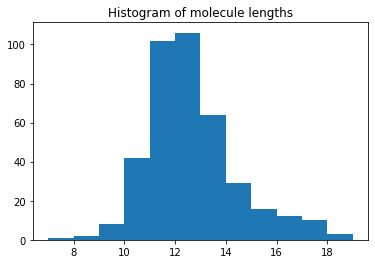

In [284]:
plt.hist(pdbs_length.values(), bins=np.arange(7, 20))
plt.title(f"Histogram of molecule lengths")

Text(0.5, 1.0, 'Histogram of number of rotatable bonds')

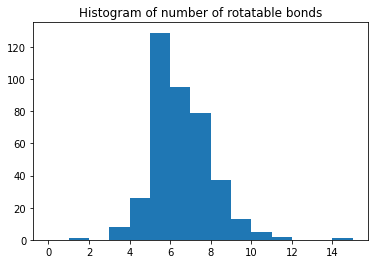

In [285]:
plt.hist(pdbs_rotbonds.values(), bins=np.arange(0, 16))
plt.title(f"Histogram of number of rotatable bonds")

Note that with each run, the predicted longest molecules changes. I suspect this is because a slightly different conformation is predicted each time. The difference doesn't seem to be greater than 1 A and in rounding up the box size in section 1.3, these molecules should still all be well accomadated within the search space

## Receptor preparation

The structure file PFATP4_3temp_116_end_relaxed_model_1.pdb, which was produced by Erisilia was downloaded from their github https://github.com/ersilia-os/osm-pfatp4-structure
This structure was produced with colabfold and MM2seq MSA. It has a pLDDT of XX, which is the highest achieved with colabfold and produced good results in [Qui et al 2022] 

File was renamed to PFATP4_Ersilia_WT.pdb for convenience

To perform the G358S mutation, the structure file was submitted to CharmmGui's pdb reader
- all 1149 residues were selected
- hydrogen coordinates were preserved
- As the first 115 residues were trimmed, the resid is offset by 115. As such G358's resid within the file was 243, and this was the res selected to perform mutagenesis on
- No protonations added as pH is essentially neutral, so defaults are probably fine [And ithink charges are handled by VIna anyway]
- Disulfides were added to Cysteines 1003-1015 and 921 and-942 (index 1). Note that Cys 1100-1112 are also in close proximity but not such that VMD thought there would be a bond. Could be a real disulfide but it looks buried, so its not something consequential for the static docking here, but could be important if we proceed with molecular dynamics simulations
- Pdb was downloaded and saved as PFATP4_Ersilia_G358S.pdb


The dimensions of a search space / box must be specified. As this series of docking runs is only to ascertain whether the G358S mutant might effect the binding of the compounds, our box will only encompass the space surrounding the G358. The longest molecule in the dataset is 18.6 A (As determined in section 1.2.1). And so the box size will be large enough to fit this molecule. 

In [220]:
# Here I will calculate suitable box dimensions based on the coordinates of the G358
# and the size of the longest molecule

# Get center of mass of G358 - this will be the box center
u = mda.Universe('receptor_prep/PFATP4_Ersilia_WT.pdb')
g358 = u.select_atoms('resid 243') 
g358_com = g358.center_of_mass()

# The box shall be a cube of sides length longest molecule * 2 so it fits in either direction
box_len = longest_dist * 2 


# I'll round up to 40 for cleanliness and good luck
print(f"box center: {g358_com}\t box_length: {box_len}")

box center: [-23.78727967 -11.67114386   6.62036549]	 box_length: 39.63935165968283


Next I will visually confirm that these coordinates and box size makes sense using the Autodock tools GUI as well as generating the required .pdbqt for docking. The screenshot below shows the position and size of the box in relation to the pfatp4 structure. G358 is shown in vdw representation. I've rounded the coordinates to int for simplicity

![pfatp4_box](pfatp4_OSM-docking_box-visual.png)

And the side view ...

![pfatp4_box_side](pfatp4_OSM-docking_box-visual_side.png)

This box size should be more than enough, and may infact be unneccessarily large. We'll see if we have convergence issues. Otherwise, the official box parameters are (in Angstrom):  

    x center: -24
    y center: -12
    z center: 7
    
    box length: 40 
    

Note that the protein is not aligned along any of the axises so the search space is angled. This is fine for a small box but if we do a full blind search in future, we might need to align the protein along an axis

## Convergence test

It is important that the docking is able to sufficiently sample the search space we have just defined. To determine that an exhaustiveness is enough to do just that I will run a number of increasing exhauustivenesses with three replicates. The lowest Ex where all three replicates have the same (generally considered to be an RMSD < 2) top pose is the Ex I will use for the rest of the dataset. This will only be performed for the molecule with the most number of rotatable bonds. 

### Directory setup

In [236]:
from itertools import product
import sys, os, os.path 
from subprocess import call

In [286]:
cd /home/john/Documents/OSM4_docking/Docking_convergence-test

/home/john/Documents/OSM4_docking/Docking_convergence-test


In [287]:
# Ensure that file paths correspond to where the files are located in relation to the parent folder of the 
# docking runs. i.e Docking_convergence-test in this case

methods = ['ADV']
receptors = ['Receptors/PFATP4_Ersilia_WT.pdbqt']
ligands = [floppiest_mol.split('/', maxsplit=1)[-1]+'qt']
boxes = ['BC']
exs = [2**i for i in range(3, 10)]
reps = range(3)

Don't forget to copy floppiest mol .pdbqt over to Ligands/

In [294]:
def name_dir(method, receptor, ligand, box, ex, rep):
    
    rec = receptor.rsplit('/')[-1].rsplit('.', maxsplit=1)[0].split('_')[-1]
    lig = ligand.rsplit('/')[-1].rsplit('.', maxsplit=1)[0]
    
    name = f'DockingRun_{method}_{rec}_{lig}_box-{box}_ex-{ex}_rep-{rep}'
    
    return name
    


def setup_folder(method, receptor, ligand, box, ex, rep, dirname_func=None, overwrite=False):
    
    # Create the direcotry name
    dirname = dirname_func(method, receptor, ligand, box, ex, rep)

    
    # Check if it already exists and skip it if not overwriting
    if os.path.isdir(dirname) and not overwrite:
        print(f"{dirname} already created, skipping... ")
        return None
    
    # Try creating the directory. If it already exists delete it
    try:
        os.mkdir(dirname)
    except FileExistsError:
        call(f'rm -r {dirname}', shell=True)
        os.mkdir(dirname)
    
    
    # Find the lig name from the ligand file path
    # The default behaviour is to output where the ligand is saved. Since I use the same file
    # for all this would mean in the Ligands dir, overwriting all results
    
    ligname = ligand.rsplit('/')[-1].rsplit('.', maxsplit=1)[0]
    

    # Replace placeholder values in config file and copy to corresponding dir
    call(f"cp config_template.txt {dirname}/config.txt", shell=True)
    call(f"sed -i 's@LIGAND@../{ligand}@' {dirname}/config.txt ", shell=True)
    call(f"sed -i 's@RECEPTOR@../{receptor}@' {dirname}/config.txt ", shell=True)
    call(f"sed -i 's@EX@{ex}@' {dirname}/config.txt ", shell=True)
    call(f"sed -i 's@LIGNAME@{ligname}_out.pdbqt@' {dirname}/config.txt ", shell=True)

    # Create empty file to hold the docking log contents
    open(f'{dirname}/log.txt', 'w').close()
    


In [295]:
# Create the directories for the convergence run
parameter_combinations = product(methods, receptors, ligands, boxes, exs, reps)
for param in parameter_combinations:
#     print(param)
    setup_folder(*param, dirname_func=name_dir, overwrite=True)
    

In [290]:
# Confirm creation
!ls

config_template.txt
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-128_rep-0
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-128_rep-1
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-128_rep-2
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-16_rep-0
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-16_rep-1
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-16_rep-2
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-256_rep-0
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-256_rep-1
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-256_rep-2
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-32_rep-0
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-32_rep-1
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-32_rep-2
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-512_rep-0
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-512_rep-1
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-512_rep-2
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-64_rep-0
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-64_rep-1
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-64_rep-2
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-8_rep-0
DockingRun_ADV_WT_OSM-S-639_box-BC_ex-8_rep-1
DockingRun_ADV_WT_OSM-S-639_box-B

Directories were copied over to the supercomputer (Gadi @NCI Australia), and ran there.

Times:

### Convergence / Reproducibility Analysis

To determine which Ex is most appropriate I will calculate the RMSD of the top pose of each of the replicates to each other.

In [659]:
cd /home/john/Documents/OSM4_docking/Docking_convergence-test/

/home/john/Documents/OSM4_docking/Docking_convergence-test


In [644]:
from spyrmsd.rmsd import symmrmsd
from spyrmsd import io

In [643]:
Exes = [2**i for i in range(3, 10)]
Exes

[8, 16, 32, 64, 128, 256, 512]

In [690]:
ex_graphing = []
rmsds_graphing = []
averages = []
for ex in Exes:
    
    # get files for that ex
    toppose_files = glob(f'DockingRun*ex-{ex}*/*out_ligand_1.pdbqt')
    
    # find unique pose file pairs, so no RMSD values are duplicates
    toppose_pairs = set()
    for i in toppose_files:
        for j in toppose_files:
            pair = frozenset([i,j])
            if len(pair) == 2:
                toppose_pairs.add(pair)
    
    
    # Calculate the rmsd
    rmsds = []
    for pair in toppose_pairs:
        pair = list(pair)
        pose1 = io.loadmol(pair[0])
        pose2 = io.loadmol(pair[1])
        
        rmsd = symmrmsd(pose1.coordinates, pose2.coordinates,
                            pose1.atomicnums, pose2.atomicnums,
                            pose1.adjacency_matrix, pose2.adjacency_matrix)
        
        rmsds_graphing.append(rmsd)
        rmsds.append(rmsd)
        ex_graphing.append(ex)
    
    averages.append(np.mean(rmsds))

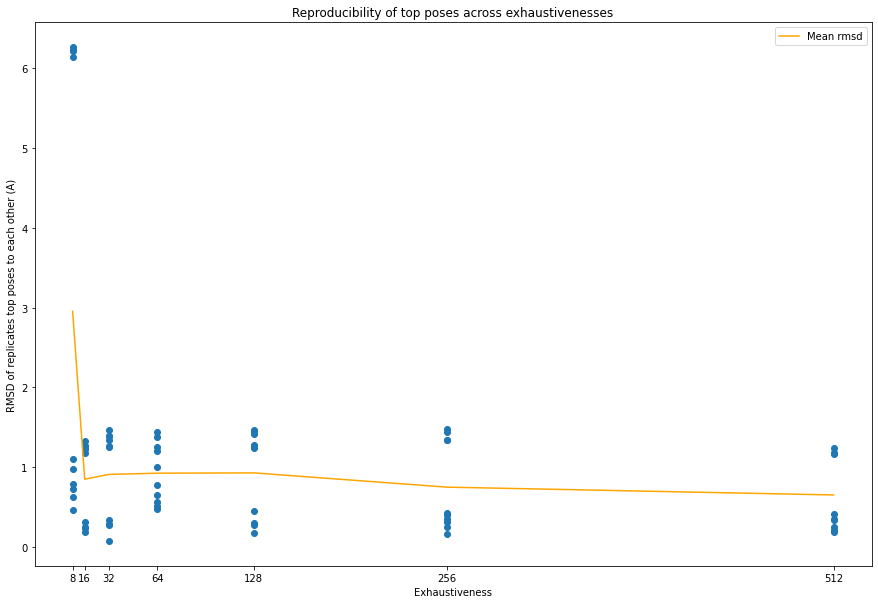

In [700]:
plt.figure(figsize=(15,10))
plt.scatter(ex_graphing, rmsds_graphing)
plt.plot(Exes, averages, color='orange', label='Mean rmsd')
plt.title('Reproducibility of top poses across exhaustivenesses')
plt.xticks(Exes)
plt.xlabel('Exhaustiveness')
plt.ylabel('RMSD of replicates top poses to each other (A)')
plt.legend()

To determine which exhaustiveness would give reproducible results, we ran 5 replicates at exhaustivenesses increasing exponentially from 8 to 512. The RMSD of the top poses from each of the replicates for a particular Ex, was calculated between each other.  Exhaustiveness is the number of independent searches performed over the search space. 

The mean rmsd drops rapidly after 8 ex, and more ex does not lead to any significant improvements after 16. All values are below and RMSD of 2, indicating that the same pose is being reproduced. Therefore, we will run the following docking simulations with an Ex of 16. This calculation takes around 12 seconds per ligand. This performance is sufficient to effectively dock the entire dataset of compounds.

## Docking setup of all compounds

In [701]:
cd /home/john/Documents/OSM4_docking/Docking_allcompounds/

/home/john/Documents/OSM4_docking/Docking_allcompounds


In [702]:
methods = ['ADV']
receptors = ['Receptors/PFATP4_Ersilia_WT.pdbqt', 'Receptors/PFATP4_Ersilia_G358S.pdbqt']
ligands = osm_all
boxes = ['BC']
exs = [16]
reps = range(1)

In [704]:
# Create dirs
parameter_combinations = product(methods, receptors, ligands, boxes, exs, reps)
for param in parameter_combinations:
    print(param)
    setup_folder(*param, dirname_func=name_dir, overwrite=False)
    

('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-380.pdbqt', 'BC', 16, 0)
DockingRun_ADV_WT_OSM-S-380_box-BC_ex-16_rep-0 already created, skipping... 
('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-201.pdbqt', 'BC', 16, 0)
DockingRun_ADV_WT_OSM-S-201_box-BC_ex-16_rep-0 already created, skipping... 
('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-202.pdbqt', 'BC', 16, 0)
DockingRun_ADV_WT_OSM-S-202_box-BC_ex-16_rep-0 already created, skipping... 
('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-189.pdbqt', 'BC', 16, 0)
DockingRun_ADV_WT_OSM-S-189_box-BC_ex-16_rep-0 already created, skipping... 
('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-366.pdbqt', 'BC', 16, 0)
DockingRun_ADV_WT_OSM-S-366_box-BC_ex-16_rep-0 already created, skipping... 
('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-

## Docking setup of new candidates

In [705]:
cd /home/john/Documents/OSM4_docking/Docking_newcandidates/

/home/john/Documents/OSM4_docking/Docking_newcandidates


In [707]:
methods = ['ADV']
receptors = ['Receptors/PFATP4_Ersilia_WT.pdbqt', 'Receptors/PFATP4_Ersilia_G358S.pdbqt']
ligands = osm_new
boxes = ['BC']
exs = [16]
reps = range(1)

In [708]:
# Create dirs
parameter_combinations = product(methods, receptors, ligands, boxes, exs, reps)
for param in parameter_combinations:
    print(param)
    setup_folder(*param, dirname_func=name_dir, overwrite=False)
    

('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_newcandidates/Ligands//OSM-LO-75.pdbqt', 'BC', 16, 0)
DockingRun_ADV_WT_OSM-LO-75_box-BC_ex-16_rep-0 already created, skipping... 
('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_newcandidates/Ligands//OSM-LO-70.pdbqt', 'BC', 16, 0)
DockingRun_ADV_WT_OSM-LO-70_box-BC_ex-16_rep-0 already created, skipping... 
('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_newcandidates/Ligands//OMS-LO-74.pdbqt', 'BC', 16, 0)
DockingRun_ADV_WT_OMS-LO-74_box-BC_ex-16_rep-0 already created, skipping... 
('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_newcandidates/Ligands//OSM-LO-71.pdbqt', 'BC', 16, 0)
DockingRun_ADV_WT_OSM-LO-71_box-BC_ex-16_rep-0 already created, skipping... 
('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_newcandidates/Ligands//OSM-LO-73.pdbqt', 'BC', 16, 0)
DockingRun_ADV_WT_OSM-LO-73_box-BC_ex-16_rep-0 already created, skipping... 
('ADV', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_newcandidates/Ligands

## Docking setup of all compounds using Gnina

In [1049]:
cd /home/john/Documents/OSM4_docking/Docking_Gnina_allcompounds/

/home/john/Documents/OSM4_docking/Docking_Gnina_allcompounds


In [1050]:
methods = ['GNINA']
receptors = ['Receptors/PFATP4_Ersilia_WT.pdbqt', 'Receptors/PFATP4_Ersilia_G358S.pdbqt']
ligands = osm_all
boxes = ['BC']
exs = [16]
reps = range(1)

In [1051]:
# Create dirs
parameter_combinations = product(methods, receptors, ligands, boxes, exs, reps)
for param in parameter_combinations:
    print(param)
    setup_folder(*param, dirname_func=name_dir, overwrite=False)

('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-380.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-201.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-202.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-189.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-366.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-206.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-410.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-411.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-412.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptor

('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-518.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-519.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-520.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-521.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-531.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-532.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-533.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-535.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-536.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptor

('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-629.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-630.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-632.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-633.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-639.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-LO-2.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-LO-4.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-LO-5.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-LO-6.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PF

('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-062.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-092.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-183.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-036.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-011.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-072.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-065.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-078.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-083.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptor

('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-027.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-034.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-008.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-041.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-073.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-204.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-254.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-265.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-258.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptor

('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-W-5.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-W-6.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-W-7.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-W-8.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_WT.pdbqt', 'Docking_allcompounds/Ligands//OSM-W-9.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-380.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-201.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-202.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-189.pdbqt', 'BC', 16, 0)
('GNINA', 'Recept

('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-523.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-524.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-525.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-526.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-527.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-528.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-529.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-530.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-518.pdbqt', 'BC',

('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-636.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-623.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-624.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-626.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-609.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-621.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-622.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-625.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-627.pdbqt', 'BC',

('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-049.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-180.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-181.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-185.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-094.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-182.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-184.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-186.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-055.pdbqt', 'BC',

('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-087.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-025.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-081.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-070.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-059.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-390.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-040.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-032.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-X-004.pdbqt', 'BC',

('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-378.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-376.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-382.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-383.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-384.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-385.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-386.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-S-389.pdbqt', 'BC', 16, 0)
('GNINA', 'Receptors/PFATP4_Ersilia_G358S.pdbqt', 'Docking_allcompounds/Ligands//OSM-E-21.pdbqt', 'BC', 

# Analysis of docking results

In [823]:
import pandas as pd
import seaborn as sns
from scipy.spatial import distance_matrix

### Functions

In [960]:
# functions to find IC50 correlation

# load csv to get ID and IC50
# find dock score of a pose

# load csv into df, get list of tups of IDs, dock score
# merge df
# df.corr
# plt.scatter

def get_ic50_and_score(csv, docking_dir=None):
    
    df_ic50 = upload_osm_csv(csv)
    
    id_scores = []
    
    # Make sure all ic50s are valid numbers
    df_ic50['IC50'] = pd.to_numeric(df_ic50['IC50'], errors='coerce')
    # Ic50 values not able to be converted to float, assumed to contain > symbol,
    # will be turned into Nan and then to 25
    df_ic50['IC50'].fillna(25.0, inplace=True)
    
    
    for ID in df_ic50['ID']:
        
        score = get_pose_score(ID)
        id_scores.append((ID, score))
    
    
    df_scores = pd.DataFrame(id_scores, columns=['ID', 'score'])
    df = pd.merge(df_ic50, df_scores)
    
    return df
    
def upload_osm_csv(csv):
    return pd.read_csv(csv, names=['ID', 'smiles', 'IC50'], usecols=range(3), header=1)
    
def get_pose_score(ID, fileform=lambda i: glob(f'DockingRun*WT*{i}*/{i}_out_ligand_1.pdbqt')[0]):
    
    try:
        toppose = fileform(ID)
    except IndexError:
        print(f'No file found for {ID}. Returning NaN')
        return np.nan
    
    
    with open(toppose, 'r') as file:
        vina_results = file.readlines()[0]
    
    score = float(vina_results.split()[3])
    
    return score


### Effect of G358S on binding pose and score
# for each compound, get WT and G358S toppose
# calc score difference
# RMSD to each other
# distance to G358S

def get_IDs(csv):
    
    IDs = []
    with open(csv, 'r') as file:
        
        for line in file.readlines()[1:]:
            ID = line.split(',')[0]
            IDs.append(ID)
    
    return IDs

def calc_rmsd_diff(pose1, pose2):
    
    rmsd = symmrmsd(pose1.coordinates, pose2.coordinates,
                            pose1.atomicnums, pose2.atomicnums,
                            pose1.adjacency_matrix, pose2.adjacency_matrix)
    return rmsd

# get mindist to loci
def calc_mindist_to_point(point, pose, ):
    
    distances = distance_matrix(point, pose.coordinates)
    min_dist = np.min(distances)
    
    return min_dist

# get the location of the mutation loci
# This will be used to calculate how
# far the ligand top pose moves after mutation

def get_mut_loci(receptor_file, select_str):
    u = mda.Universe(receptor_file)
    sel = u.select_atoms(select_str)
    
    if len(sel) == 1:
        return sel.positions
    else:
        pos = np.reshape(sel.center_of_mass(), (1,3))
        return pos

# For a particular compound, it will return the top pose for each of the different isoforms present
def get_topposes(ID, iso_order=None):
    
    dirform = lambda ID, iso: f'DockingRun*_{iso}_{ID}_*/*out_ligand_1.pdbqt'
    
    if iso_order is not None:
        
        out = []
        for iso in iso_order:
            search_str = dirform(ID, iso)
            files = glob(search_str)
            
            if len(files) == 1:
                out.append(files[0])
            elif len(files) > 1:
                out.append(files)
            else:
                raise Exception(f'No top pose files were found with {search_str}')
                
        return out
            
    
    else:
        return glob(dirform(ID, iso))
    
    


def mutation_effect_analysis(csv, receptor_file='Receptors/PFATP4_Ersilia_G358S.pdbqt',
                             mut_sel_str='resid 243', iso_order=['WT', 'G358S'],  ):
    
    colnames = ['ID', 'WT_score', 'Mut_score', 'score_diff',
                'RMSD_diff', 'WT pose dist to mutation', 'Mut pose dist to mutation']
    
    # get df of ids and ic50s
    df_ic50s = upload_osm_csv(csv)
    compounds = df_ic50s['ID']
    
    # Get coordinates that define position of the mutation
    G358S_loci = get_mut_loci(receptor_file, select_str=mut_sel_str)
    
    results = []
    print(len(compounds))
    
    for compound in compounds:
    
        #find mutation pair
        try:
            WT_posefile, G358S_posefile = get_topposes(compound, iso_order=iso_order)
        except Exception:
            # occurs if files aren't found
            print(f'Couldnt find anything for {compound}')
            continue
    
        # upload
        poseWT = io.loadmol(WT_posefile)
        pose358S = io.loadmol(G358S_posefile)
        
        # get scores
        scoreWT = get_pose_score(compound, fileform=lambda i: WT_posefile)
        score358S = get_pose_score(compound, fileform=lambda i:G358S_posefile)
        scorediff = scoreWT - score358S
        
        # get rmsd of poses
        rmsd = calc_rmsd_diff(poseWT, pose358S)
        
        
        # get min dist
        distWT = calc_mindist_to_point(G358S_loci, poseWT)
        dist358S = calc_mindist_to_point(G358S_loci, pose358S)
        
        
        # Row for compound in the resulting df
        compound_results = (compound, scoreWT, score358S, scorediff, rmsd,  distWT, dist358S)
        

        results.append(compound_results)
    
    analysis_df = pd.DataFrame(results, columns=colnames)

    df = pd.merge(df_ic50s, analysis_df)
    
    return df
    
        

## Does the experimental IC50 correlate with the docking scores?

In [876]:
cd /home/john/Documents/OSM4_docking/Docking_allcompounds/

/home/john/Documents/OSM4_docking/Docking_allcompounds


In [877]:
df = get_ic50_and_score('../osm_allmolecules.csv')

No file found for OSM-S-418. Returning NaN
No file found for OSM-S-564. Returning NaN


The compounds for which docking results cannot be found contain Boron (?) which freaks Vina out

In [841]:
df.corr()

,IC50,score
IC50,1.000000,0.065487
score,0.065487,1.000000


Text(0.5, 0, 'IC50 (uM)')

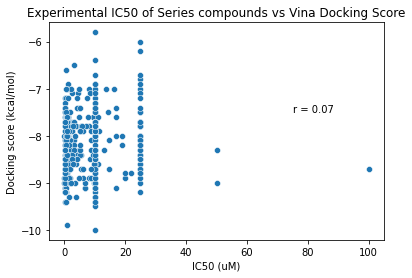

In [842]:
sns.scatterplot(data=df, x='IC50', y='score')
_=plt.title('Experimental IC50 of Series compounds vs Vina Docking Score')
r=df.corr()['score'][0]
plt.text(75 ,-7.5, f'r = {round(r,2)}')
plt.ylabel('Docking score (kcal/mol)')
plt.xlabel('IC50 (uM)')

This graph plots the series 4 IC50s for which there is experimental data against their docking scores. It shows essentially no correlation between the two values. Though IC50 from whole cell experiments is not necessairly directly related to (predicted) binding affinty, there certainly should be *some* relationship. 

This could mean several things:
1. Vina is not able to accurately represent the molecular interactions
2. The search space around G358S is not indicative of binding, i.e. it does not bind in this area. 
3. The conformation (or structure) does not capture the true binding mode. 

I would favour 1. as the explaination. This is because the average docking score is already relatively low and would be considered a good, high affinity score. Which suggests that 1. is definantly a concern, beacause if it weren't the average docking score would be lower. 

In [773]:
df['score'].mean()

-8.159114583333336

<AxesSubplot:ylabel='Frequency'>

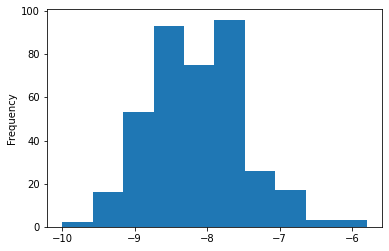

In [775]:
df['score'].plot(kind='hist')

### Docking score vs predicted IC50 for new drug candidates

In [812]:
cd /home/john/Documents/OSM4_docking/Docking_newcandidates/

/home/john/Documents/OSM4_docking/Docking_newcandidates


In [813]:
df_new = get_ic50_and_score('../osm_newcandidates.csv')

In [814]:
df_new

,ID,smiles,IC50,score
0,OSM-LO-70,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC4=CC=CC(C...,0.39150,-8.6
1,OMS-LO-74,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC4=CC=C(C(...,5.27000,-8.8
2,OSM-LO-71,ClC1=CC2=C(OCO2)C=C1COC3=CN=CC4=NN=C(C5=CC=C(O...,25.00000,-8.6
3,OSM-LO-73,FC(F)OC1=CC=C(C=C1)C1=NN=C2C=NC=C(OCCOC3=CC(F)...,1.34000,-7.7
4,OSM-LO-72,COC(COC1=CN=CC2=NN=C(N12)C1=CC=C(OC(F)F)C=C1)C...,0.07685,-8.4
5,OSM-LO-76,FC(F)OC1=CC=C(C=C1)C1=NN=C2C=NC=C(OCC3=CSC(=C3...,2.46000,-7.4
6,OSM-LO-77,FC(F)OC1=CC=C(C=C1)C1=NN=C2C=NC=C(OCC3CC4=C3C=...,0.47550,-9.6
7,OSM-S-369,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCCC4=CC=CC=...,0.16850,-8.9


In [815]:
df_new.corr()

,IC50,score
IC50,1.000000,-0.022492
score,-0.022492,1.000000


It's even worse here

## Effect of G358S mutation on binding positions and scores

#### Generate analysis dataframes

In [966]:
%cd /home/john/Documents/OSM4_docking/Docking_allcompounds/
df_allcomp = mutation_effect_analysis('../osm_allmolecules.csv', mut_sel_str='resid 243 and name OG')
df_allcomp.head()

/home/john/Documents/OSM4_docking/Docking_allcompounds
386


/home/john/anaconda3/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/john/anaconda3/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: HD
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/john/anaconda3/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: OA
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/john/anaconda3/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SA
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_

Couldnt find anything for OSM-S-418


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is Docking_allcompounds/Ligands//OSM-S-523.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is Docking_allcompounds/Ligands//OSM-S-523.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is Docking_allcompounds/Ligands//OSM-S-544.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is Docking_allcompounds/Ligands//OSM-S-544.pdb)



Couldnt find anything for OSM-S-564


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is Docking_allcompounds/Ligands//OSM-S-635.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is Docking_allcompounds/Ligands//OSM-S-635.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is Docking_allcompounds/Ligands//OSM-S-586.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is Docking_allcompounds/Ligands//OSM-S-586.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is Docking_allcompounds/Ligands//OSM-S-636.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is Docking_allcompounds/Ligands//OSM-S-636.pdb)

,ID,smiles,IC50,WT_score,Mut_score,score_diff,RMSD_diff,WT pose dist to mutation,Mut pose dist to mutation
0,OSM-S-201,Cc1c(Cl)cccc1NC(=O)c1cncc2nnc(-c3ccc(OC(F)F)cc...,4.730333,-7.6,-7.3,-0.3,7.007650,2.197118,7.844269
1,OSM-S-202,O=C(Nc1cccc(Cl)c1)c1cncc2nnc(-c3ccc(OC(F)F)cc3...,0.211000,-7.7,-7.7,0.0,0.139319,8.269901,8.138224
2,OSM-S-189,N#Cc1ccc(-c2nnc3cncc(OCCc4ccccc4Cl)n23)cc1,0.309000,-7.4,-7.6,0.2,10.564300,1.339914,4.422781
3,OSM-S-366,Fc1ccc(CCOc2cncc3nnc(-c4ccc(C(F)(F)F)nc4)n23)cc1F,0.391550,-7.5,-8.8,1.3,7.610695,1.151107,5.426296
4,OSM-S-206,O=C(Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1)c1cncc2nnc(-...,0.309000,-9.1,-9.3,0.2,0.138830,3.782925,3.652446


In [965]:
%cd /home/john/Documents/OSM4_docking/Docking_newcandidates/
df_newcand = mutation_effect_analysis('../osm_newcandidates.csv', mut_sel_str='resid 243 and name OG')
df_newcand.head()

/home/john/Documents/OSM4_docking/Docking_newcandidates
8


/home/john/anaconda3/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/john/anaconda3/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: HD
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/john/anaconda3/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: OA
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/john/anaconda3/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SA
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_

,ID,smiles,IC50,WT_score,Mut_score,score_diff,RMSD_diff,WT pose dist to mutation,Mut pose dist to mutation
0,OSM-LO-70,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC4=CC=CC(C...,0.3915,-8.6,-9.2,0.6,0.989975,4.661857,4.435956
1,OMS-LO-74,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC4=CC=C(C(...,5.27,-8.8,-8.5,-0.3,1.270816,4.250145,3.961435
2,OSM-LO-71,ClC1=CC2=C(OCO2)C=C1COC3=CN=CC4=NN=C(C5=CC=C(O...,>25,-8.6,-8.5,-0.1,2.016588,5.000259,3.805630
3,OSM-LO-73,FC(F)OC1=CC=C(C=C1)C1=NN=C2C=NC=C(OCCOC3=CC(F)...,1.34,-7.7,-7.8,0.1,1.371525,3.649687,3.654106
4,OSM-LO-72,COC(COC1=CN=CC2=NN=C(N12)C1=CC=C(OC(F)F)C=C1)C...,0.07685,-8.4,-8.4,0.0,7.294784,2.219047,3.568170


#### Distance from G358S distribution

I shall define being affected by the mutation as there being one of the predicted binding modes in proximity to the mutation and there being a difference in affinity between them. If the score difference is negative, than the 358S mutation has reduced the affinity of the compound. If positive, than the mutant has increased affinity.

The location of the serine has been defined as the position of the oxygen in its side chain. And proximity to it, as 3.5 A - this around hydrogen bonding distance to it. This cutoff is for both WT and mutatnt, so the distances of the WT poses shorter than what is typically possible. 

In [1038]:
proximity_cutoff = 3.5

# returns df of poses in proximity for the inputted df
prox = lambda df : df[(df['WT pose dist to mutation'] <= proximity_cutoff )
             | (df['Mut pose dist to mutation'] <= proximity_cutoff)]

<AxesSubplot:xlabel='WT pose dist to mutation', ylabel='Count'>

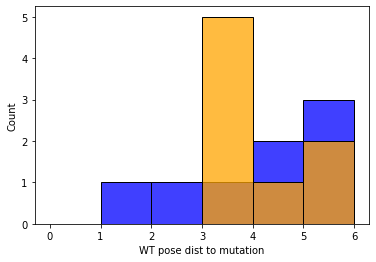

In [1058]:
sns.histplot(data=df_newcand, x='WT pose dist to mutation', bins=range(0, 7,1), color='blue')
sns.histplot(data=df_newcand, x='Mut pose dist to mutation', bins=range(0, 7,1), color='orange')

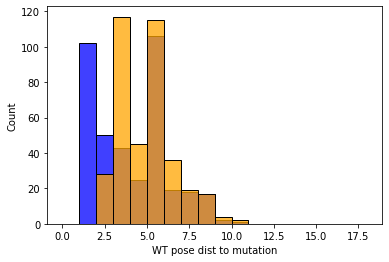

In [1060]:
sns.histplot(data=df_allcomp, x='WT pose dist to mutation', bins=range(0, 19,1), color='blue')
sns.histplot(data=df_allcomp, x='Mut pose dist to mutation', bins=range(0, 19,1), color='orange')
plt.xticks=range(0, 19,1)

In [1061]:
print(f'{len(prox(df_newcand))} of the new compounds bind in proximity to G358S')
print(f'{len(prox(df_allcomp))} of all compounds bind in proximity to G358S')

2 of the new compounds bind in proximity to G358S
184 of all compounds bind in proximity to G358S


#### Effect of mutation on compounds that can bind in proximity

In [1042]:
from IPython.display import display
def show_effects(df):
    
    
    df_cut = prox(df)[df['score_diff'] < 0]
    print(f'Compounds for which the mutation decreases affinty (prediction: reduced susceptbility)')
    print(f'{len(df_cut)} compounds total')
    display(df_cut.head())
    print('#################################')
    print()
    
    df_cut = prox(df)[df['score_diff'] > 0]
    print(f'Compounds for which the mutation increases affinty (prediction: increased susceptbility)')
    print(f'{len(df_cut)} compounds total')
    display(df_cut.head())
    print('#################################')
    print()
    
    df_cut = prox(df)[df['score_diff'] == 0]
    print(f'Compounds for which the mutation causes no change (prediction: no effect?)')
    print(f'{len(df_cut)} compounds total')
    display(df_cut.head())
    print('#################################')
    print()
    


In [1052]:
show_effects(df_newcand)

Compounds for which the mutation decreases affinty (prediction: reduced susceptbility)
0 compounds total


/tmp/ipykernel_484628/3239526786.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cut = prox(df)[df['score_diff'] < 0]


,ID,smiles,IC50,WT_score,Mut_score,score_diff,RMSD_diff,WT pose dist to mutation,Mut pose dist to mutation


#################################

Compounds for which the mutation increases affinty (prediction: increased susceptbility)
1 compounds total


/tmp/ipykernel_484628/3239526786.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cut = prox(df)[df['score_diff'] > 0]


,ID,smiles,IC50,WT_score,Mut_score,score_diff,RMSD_diff,WT pose dist to mutation,Mut pose dist to mutation
5,OSM-LO-76,FC(F)OC1=CC=C(C=C1)C1=NN=C2C=NC=C(OCC3=CSC(=C3...,2.46,-7.4,-8.0,0.6,6.995817,1.524801,3.739392


#################################

Compounds for which the mutation causes no change (prediction: no effect?)
1 compounds total


/tmp/ipykernel_484628/3239526786.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cut = prox(df)[df['score_diff'] == 0]


,ID,smiles,IC50,WT_score,Mut_score,score_diff,RMSD_diff,WT pose dist to mutation,Mut pose dist to mutation
4,OSM-LO-72,COC(COC1=CN=CC2=NN=C(N12)C1=CC=C(OC(F)F)C=C1)C...,0.07685,-8.4,-8.4,0.0,7.294784,2.219047,3.56817


#################################



The docking predicts that none of the new candidates will have a reduced susceptibility, OSM-LO-76 will have increased affinty towards G358S. This would be great, if I actually believed the results. See section 2.1.  

OSM-LO-72, the compound with the lowest IC50, binds in proximity, but does not have any predicted change in affinity upon mutating the protein. I'm not super convinced that if it did bind there (big if), that the introduction of a serine would not have any effect on affinity. So I can't say if it should increase or decrease affinity, but surely it's not zero. 

In [1044]:
show_effects(df_allcomp)

Compounds for which the mutation decreases affinty (prediction: reduced susceptbility)
70 compounds total


/tmp/ipykernel_484628/3239526786.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cut = prox(df)[df['score_diff'] < 0]


,ID,smiles,IC50,WT_score,Mut_score,score_diff,RMSD_diff,WT pose dist to mutation,Mut pose dist to mutation
0,OSM-S-201,Cc1c(Cl)cccc1NC(=O)c1cncc2nnc(-c3ccc(OC(F)F)cc...,4.730333,-7.6,-7.3,-0.3,7.007650,2.197118,7.844269
5,OSM-S-410,O=C(Nc1ccc(Cl)cc1)c1c[nH]c(=O)c2nnc(-c3ccc(OC(...,5.000000,-7.9,-7.3,-0.6,6.653922,1.464499,8.048493
6,OSM-S-411,O=C(Nc1cc[n+]([O-])c(C(F)(F)F)c1)c1cncc2nnc(-c...,2.070000,-7.8,-7.5,-0.3,6.598884,1.023558,2.759246
11,OSM-S-394,FS(F)(F)(F)(F)c1ccc(-c2nnc3cncc(OCCc4ccccc4)n2...,0.480000,-7.6,-7.4,-0.2,8.196715,1.205946,7.791954
19,OSM-S-402,Clc1ccc(-c2nnc3cncc(OCC45CC6CC(CC(C6)C4)C5)n23...,2.530000,-7.1,-7.0,-0.1,6.861494,1.393604,8.290907


#################################

Compounds for which the mutation increases affinty (prediction: increased susceptbility)
104 compounds total


/tmp/ipykernel_484628/3239526786.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cut = prox(df)[df['score_diff'] > 0]


,ID,smiles,IC50,WT_score,Mut_score,score_diff,RMSD_diff,WT pose dist to mutation,Mut pose dist to mutation
2,OSM-S-189,N#Cc1ccc(-c2nnc3cncc(OCCc4ccccc4Cl)n23)cc1,0.30900,-7.4,-7.6,0.2,10.564300,1.339914,4.422781
3,OSM-S-366,Fc1ccc(CCOc2cncc3nnc(-c4ccc(C(F)(F)F)nc4)n23)cc1F,0.39155,-7.5,-8.8,1.3,7.610695,1.151107,5.426296
10,OSM-S-393,COC(COc1cncc2nnc(-c3ccc(OC(F)F)cc3)n12)(OC)c1c...,0.15700,-7.2,-8.1,0.9,9.252952,2.212463,4.017581
14,OSM-S-397,FC(F)Oc1ccc(-c2nnc3cncc(OCC45CC6CC(CC(C6)C4)C5...,4.80000,-7.4,-8.0,0.6,1.467825,2.291821,3.524912
18,OSM-S-401,Clc1ccc(-c2nnc3cncc(OCC45CC6CC(CC(C6)C4)C5)n23...,8.00000,-7.0,-7.1,0.1,7.086470,1.534136,7.791124


#################################

Compounds for which the mutation causes no change (prediction: no effect?)
10 compounds total


/tmp/ipykernel_484628/3239526786.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cut = prox(df)[df['score_diff'] == 0]


,ID,smiles,IC50,WT_score,Mut_score,score_diff,RMSD_diff,WT pose dist to mutation,Mut pose dist to mutation
48,OSM-S-507,O=C(c1ccc(-c2nnc3cncc(OCCc4ccc(F)c(F)c4)n23)cc...,10.00,-8.5,-8.5,0.0,6.131831,1.534959,3.372713
87,OSM-S-543,Fc1ccc(CCOc2nccn3c(-n4cccn4)nnc23)cc1F,19.00,-8.0,-8.0,0.0,0.367972,2.264796,2.955092
146,OSM-S-621,c1ccc(CCOc2nccn3c(-c4ccccc4)nnc23)cc1,8.73,-7.9,-7.9,0.0,20.714994,9.860264,3.403171
149,OSM-S-627,COc1ccc(-c2nnc3c(SCCc4ccccc4)nccn23)cc1,25.00,-8.0,-8.0,0.0,0.757025,2.372913,2.756402
182,OSM-S-678,O=[N+]([O-])c1ccccc1-c1nnc2cncc(OCCc3ccccc3)n12,25.00,-7.1,-7.1,0.0,0.210235,3.120777,3.458731


#################################



### Sanity check: Binding pose reproducibility

If a compound does not bind in proximimty to G358S in either isoform, than the binding position should be the same between isoforms if we have sampled sufficiently. 

To assess this I will look at the RMSD difference between poses not in proximity to G358S.

In [1045]:
df_combined = pd.concat([df_allcomp, df_newcand])
df_combined.index = range(len(df_combined))

In [1046]:
# select df of those not in proximity
df_notprox = df_combined[~df_combined.isin(prox(df_combined))].dropna()

Text(0.5, 1.0, 'RMSD difference of poses between isoforms (for those not in proximity to G358S)')

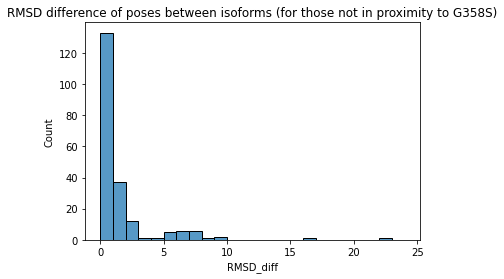

In [1047]:
sns.histplot(data=df_notprox, x='RMSD_diff', bins=range(0,25,1))
plt.title('RMSD difference of poses between isoforms (for those not in proximity to G358S)')

If the Exhaustiveness is sufficient, then ideally, all RMSD_diff values would be less than 2A (If an RMSD < 2A is considered an identical pose). Majority are under 2A. Energy landscapes can be very rugged, so I'm not super concerned that for the number of poses >2A RMSD diff is indicative of systematic undersampling. 